In [1]:
%pylab inline
import lib
lib.cmdstan_path('/Users/maedoc/cmdstan-2.17.0/')

Populating the interactive namespace from numpy and matplotlib


'/Users/maedoc/cmdstan-2.17.0/'

# toy data

We just want to test that model can fit given EI pattern,
where the simplest interesting scenario would be to seizure
initiation, propagation and another node which doesn't partipate.
We'll start with just 3 nodes

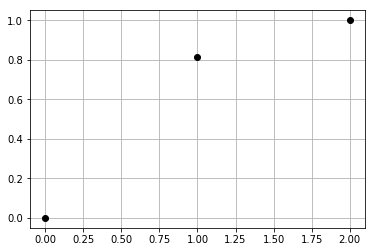

In [78]:
w = abs(randn(21, 21)) # np.loadtxt('trec.d/weights.txt')
n = 3
w = ones((n, n))
w = w[-n:, -n:]
np.fill_diagonal(w, 0)
w /= w.max()

data = {
     "n": n,
     "ns": 50,
     "T": 10.0,
     "w": w**0.5,
     "ei": np.r_[:1.0:1j*n]**0.3,
    "tau": 30.0
}
plot(data['ei'], 'ko'), grid(1)
lib.rdump('vep-ode-ei.R', data)

In [22]:
!h=`pwd`;cd $CMDSTAN; make $h/vep-ode-ei; cd $h


--- Translating Stan model to C++ code ---
bin/stanc  /Users/maedoc/Sources/TVB/VEP/vep-ode-ei.stan --o=/Users/maedoc/Sources/TVB/VEP/vep-ode-ei.hpp
Model name=vep_ode_ei_model
Input file=/Users/maedoc/Sources/TVB/VEP/vep-ode-ei.stan
Output file=/Users/maedoc/Sources/TVB/VEP/vep-ode-ei.hpp
DIAGNOSTIC(S) FROM PARSER:
 Positive values rounded down, negative values rounded up or down in platform-dependent way.
 Positive values rounded down, negative values rounded up or down in platform-dependent way.


--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -stdlib=libc++ -Wno-unknown-warning-option -Wno-unused-function -Wno-tautological-compare -Ws

In [81]:
%%bash
m=vep-ode-ei
rm $m.*.csv $m.*.out
for i in {1..2}
do
./$m id=$i sample \
     save_warmup=1 num_warmup=200 num_samples=200 \
            adapt \
                delta=0.8 \
            algorithm=hmc \
                engine=nuts \
                    max_depth=8 \
     data file=vep-ode-ei.R \
     output refresh=1 file=vep-ode-ei.$i.csv &> vep-ode-ei.$i.out &
done

In [91]:
! for i in {1..2}; do tail -n1 vep-ode-ei.$i.out; done

Iteration:  11 / 400 [  2%]  (Warmup)
Iteration:  10 / 400 [  2%]  (Warmup)


In [80]:
!killall vep-ode-ei

No matching processes belonging to you were found


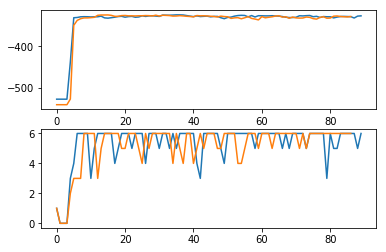

In [75]:
csv = lib.parse_csv('vep-ode-ei.*.csv', merge=False)
subplot(211); [plot(c['lp__']) for c in csv];
subplot(212); [plot(c['treedepth__']) for c in csv];

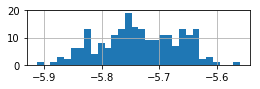

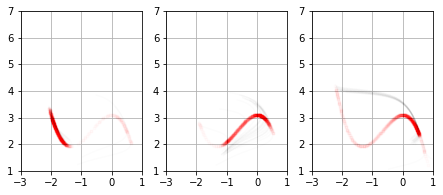

In [76]:
csv = lib.parse_csv('vep-ode-ei.*.csv')
globals().update(csv)

xze = xze.reshape((-1, 3, n, 50))

figure(figsize=(4, 1)); hist(log(k), 30); grid(1);

figure(figsize=(10, 10))
for i in range(n):
    subplot(3, 4, i + 1)
    x = xze[::10, 0, i].T
    z = xze[::10, 1, i].T
    plot(x, z, 'k', alpha=0.01)
    x_ = x.flat[:]
    plot(x, 3.1 - x * x * x - 2 * x * x, 'r.', alpha=0.01)
    axis([-3, 1.0, 1, 7])
    grid(1)

In [45]:
xze.shape

(800, 3, 3, 50)

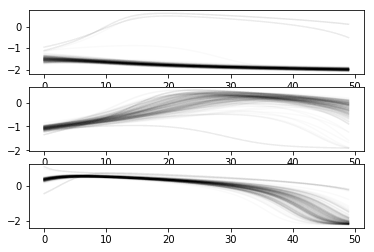

In [77]:
x, z, e = transpose(xze, (1, 2, 0, 3))
e.shape

for i, e_ in enumerate(x):
    subplot(3, 1, i + 1), plot(e_.T, 'k', alpha=0.02)